In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
gc.enable()

train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
train_det = train.where(train['detected'] == 1)
train_u = train_det.where(np.logical_or(train_det['passband'] == 0, train_det['passband'] == 1))
train_r = train_det.where(np.logical_or(train_det['passband'] == 2, train_det['passband'] == 3))
train_z = train_det.where(np.logical_or(train_det['passband'] == 4, train_det['passband'] == 5))

aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std','skew', 'cumsum'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

aggs_det = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['mean', 'std', 'var'],
    'flux': ['min', 'max', 'skew'],
}

aggs_bands = {
    'flux': ['mean', 'skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
agg_train_det = train_det.groupby('object_id').agg(aggs_det)
agg_train_u = train_u.groupby('object_id').agg(aggs_bands)
agg_train_r = train_r.groupby('object_id').agg(aggs_bands)
agg_train_z = train_z.groupby('object_id').agg(aggs_bands)

new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
new_columns_det = [
    k + '_' + agg for k in aggs_det.keys() for agg in aggs_det[k]
]
new_columns_bands = [
    k + '_' + agg for k in aggs_bands.keys() for agg in aggs_bands[k]
]

agg_train.columns = new_columns
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

agg_train_det.columns = new_columns_det
agg_train_det['mjd_diff'] = agg_train_det['mjd_max'] - agg_train_det['mjd_min']
agg_train_det['flux_diff'] = agg_train_det['flux_max'] - agg_train_det['flux_min']
agg_train_det['flux_kurt'] = train_det.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

agg_train_u.columns = new_columns_bands
agg_train_u['flux_kurt'] = train_u.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_r.columns = new_columns_bands
agg_train_r['flux_kurt'] = train_r.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
agg_train_z.columns = new_columns_bands
agg_train_z['flux_kurt'] = train_z.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

agg_train_det.columns = agg_train_det.columns + "_det"
agg_train_u.columns = agg_train_u.columns + "_u"
agg_train_r.columns = agg_train_r.columns + "_r"
agg_train_z.columns = agg_train_z.columns + "_z"

del agg_train_det['mjd_max_det'], agg_train_det['mjd_min_det']
del agg_train_det['flux_max_det'], agg_train_det['flux_min_det']

agg_train = pd.concat([agg_train, agg_train_det], axis=1, join='inner')
agg_train['u_r_colour'] = agg_train_u['flux_mean_u'] - agg_train_r['flux_mean_r']
agg_train['r_z_colour'] = agg_train_r['flux_mean_r'] - agg_train_z['flux_mean_z']

agg_train.index = agg_train.index.map(int)
agg_train.index.name = 'object_id'

del train, train_det, train_u, train_r, train_z, agg_train_det, agg_train_u, agg_train_r, agg_train_z
gc.collect()

126

In [3]:
meta_train = pd.read_csv('training_set_metadata_head_oldlab.csv')

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

full_train['distmod'].fillna(0, inplace=True)

full_train['mod_max_flux'] = full_train['flux_max'] * (1 + full_train['distmod'])

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [4]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)
print(len(train_mean))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

37


In [5]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

C:\Users\Ross\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [8]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [9]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [10]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [11]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [12]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

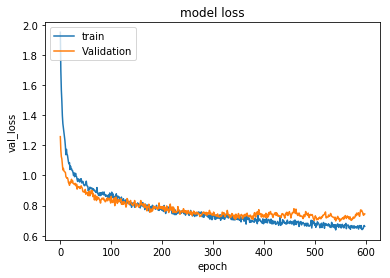

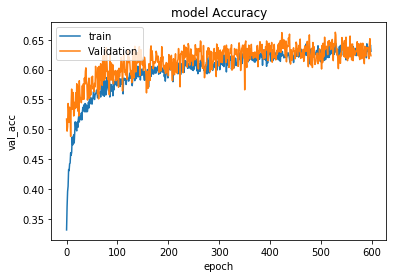

Loading Best Model
0.6969635463482362


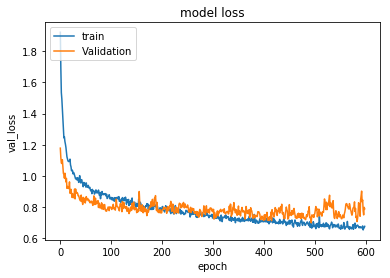

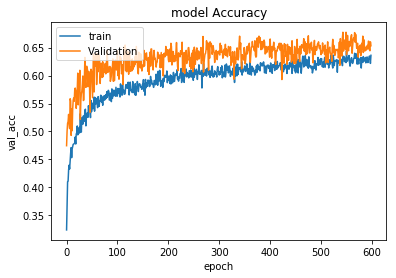

Loading Best Model
0.6978533696684774


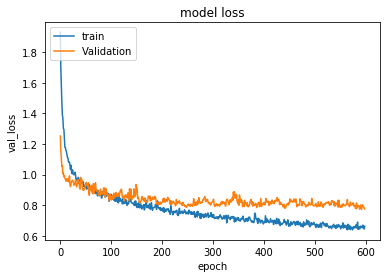

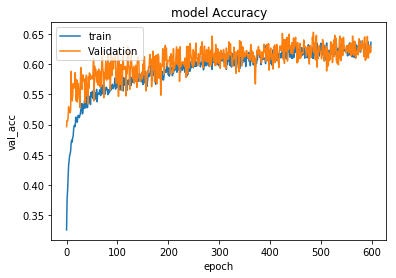

Loading Best Model
0.7511535869081263


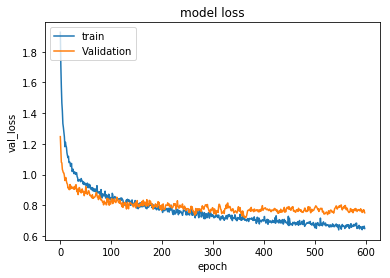

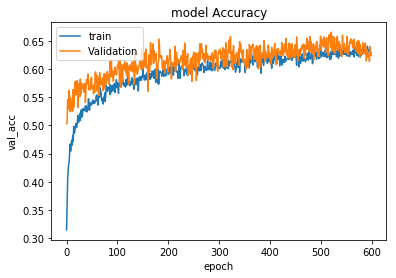

Loading Best Model
0.7220567897205115


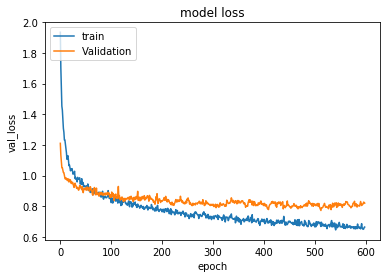

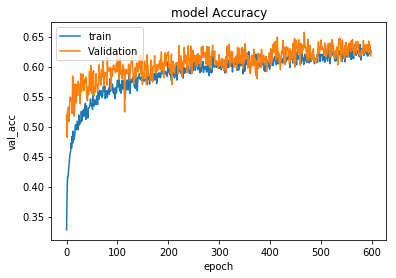

Loading Best Model
0.7670318924476335
MULTI WEIGHTED LOG LOSS : 0.72716 


In [13]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [16]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

2910

Normalized confusion matrix
[[9.40e-01 0.00e+00 1.99e-02 0.00e+00 0.00e+00 1.32e-02 0.00e+00 0.00e+00
  1.32e-02 0.00e+00 0.00e+00 0.00e+00 1.32e-02 0.00e+00]
 [0.00e+00 7.45e-01 0.00e+00 2.02e-02 2.42e-02 0.00e+00 3.64e-02 4.24e-02
  0.00e+00 5.25e-02 4.04e-03 6.26e-02 0.00e+00 1.21e-02]
 [6.49e-03 0.00e+00 9.70e-01 0.00e+00 0.00e+00 1.08e-03 0.00e+00 0.00e+00
  5.41e-03 0.00e+00 0.00e+00 0.00e+00 1.73e-02 0.00e+00]
 [0.00e+00 1.17e-01 0.00e+00 2.33e-01 1.52e-01 0.00e+00 1.74e-01 4.95e-02
  0.00e+00 8.89e-02 1.68e-03 1.58e-01 0.00e+00 2.77e-02]
 [0.00e+00 5.46e-02 0.00e+00 4.92e-02 3.61e-01 0.00e+00 9.29e-02 3.28e-02
  0.00e+00 1.15e-01 0.00e+00 2.90e-01 0.00e+00 5.46e-03]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.89e-02 0.00e+00 6.61e-02 1.14e-01 0.00e+00 3.70e-01 8.26e-02
  0.00e+00 2.62e-01 0.00e+00 6.40e-02 0.00e+00 1.24e-02]
 [0.00e+00 2.94e-02 0.00e+00 1.96e-02 9.80e-03 0.00e+00

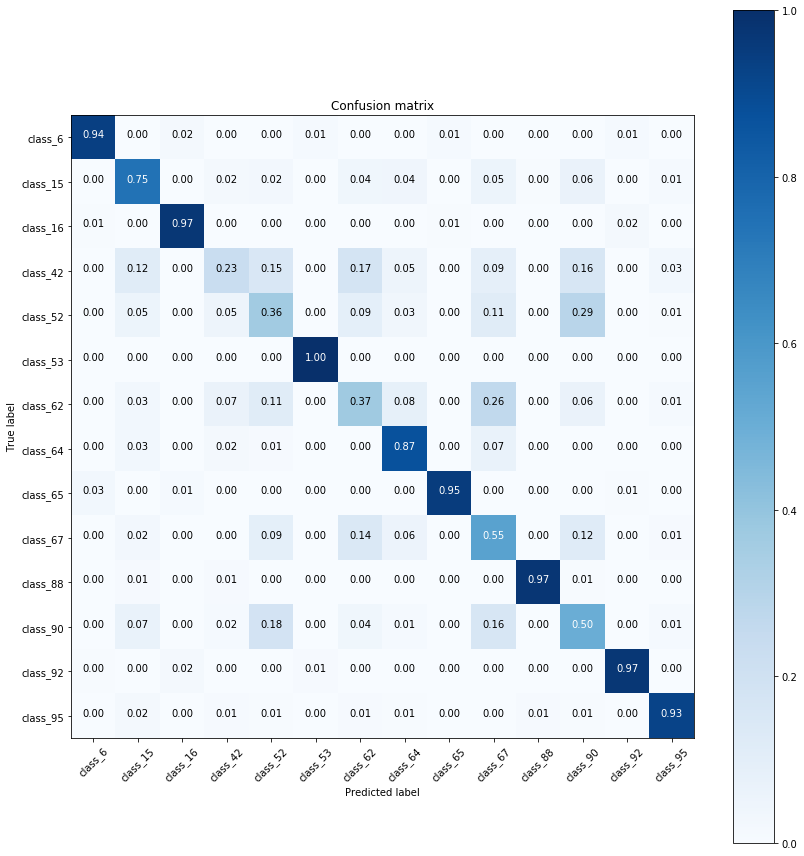

In [17]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [18]:
meta_test = pd.read_csv('test_set_metadata.csv')

import time

headis = ['object_id','mjd','passband','flux','flux_err','detected']

skips = [0, 9234918, 18406171, 27609073, 37041469, 46197790, 55770062, 64926393, 74082924, 83421236, 92557978, 102091641, 111228285,
        120365006, 129501800, 137843882, 148172034, 157308879, 166445472, 175979221, 185116017, 194649736, 203786228, 212922916,
        222059646, 231593331, 240730004, 249866875, 259003404, 268537163, 277673872, 286810516, 296344221, 305481051, 314617603,
        324151351, 333288179, 342424765, 351958414, 361095248, 370231906, 379765602, 388902239, 398038933, 407175651, 416709263,
        425846082, 434982658, 444119308, 453653104]

start = time.time()

for i_c in range(0, 49):
    df = pd.read_csv('test_set.csv', names = headis, header=None, skiprows = skips[i_c]+1, nrows = (skips[i_c+1] - skips[i_c]), low_memory = False)
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    df_det = df.where(df['detected'] == 1)
    df_u = df_det.where(np.logical_or(df_det['passband'] == 0, df_det['passband'] == 1))
    df_r = df_det.where(np.logical_or(df_det['passband'] == 2, df_det['passband'] == 3))
    df_z = df_det.where(np.logical_or(df_det['passband'] == 4, df_det['passband'] == 5))
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test_det = df_det.groupby('object_id').agg(aggs_det)
    agg_test_u = df_u.groupby('object_id').agg(aggs_bands)
    agg_test_r = df_r.groupby('object_id').agg(aggs_bands)
    agg_test_z = df_z.groupby('object_id').agg(aggs_bands)
    agg_test.columns = new_columns
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']
    agg_test_det.columns = new_columns_det
    agg_test_det['mjd_diff'] = agg_test_det['mjd_max'] - agg_test_det['mjd_min']
    agg_test_det['flux_diff'] = agg_test_det['flux_max'] - agg_test_det['flux_min']
    agg_test_det['flux_kurt'] = df_det.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

    agg_test_u.columns = new_columns_bands
    agg_test_u['flux_kurt'] = df_u.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_r.columns = new_columns_bands
    agg_test_r['flux_kurt'] = df_r.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)
    agg_test_z.columns = new_columns_bands
    agg_test_z['flux_kurt'] = df_z.groupby('object_id')['flux'].apply(pd.DataFrame.kurt)

    agg_test_det.columns = agg_test_det.columns + "_det"
    agg_test_u.columns = agg_test_u.columns + "_u"
    agg_test_r.columns = agg_test_r.columns + "_r"
    agg_test_z.columns = agg_test_z.columns + "_z"
    
    del agg_test_det['mjd_max_det'], agg_test_det['mjd_min_det']
    del agg_test_det['flux_max_det'], agg_test_det['flux_min_det']
    
    agg_test = pd.concat([agg_test, agg_test_det], axis=1, join='inner')
    agg_test['u_r_colour'] = agg_test_u['flux_mean_u'] - agg_test_r['flux_mean_r']
    agg_test['r_z_colour'] = agg_test_r['flux_mean_r'] - agg_test_z['flux_mean_z']

    agg_test.index = agg_test.index.map(int)
    agg_test.index.name = 'object_id'

    del df, df_det, df_u, df_r, df_z
    gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    
    full_test['distmod'].fillna(0, inplace=True)
    
    full_test['mod_max_flux'] = full_test['flux_max'] * (1 + full_test['distmod'])
    
    del full_test['hostgal_specz']
    del full_test['ra'], full_test['decl'], full_test['gal_l'],full_test['gal_b'],full_test['ddf']

    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    print(sum(np.logical_not(np.isfinite(full_test[full_train.columns].values))))
    print(full_test[full_train.columns].iloc[np.logical_not(np.isfinite(full_test[full_train.columns].iloc[:,31].values)),31])
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions_newmodel2.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions_newmodel2.csv',  header=False, mode='a', index=False)
        
    del agg_test, agg_test_det, full_test, preds_df, preds
#     print('done')
    print('%15d done in %5.1f' % ((i_c + 1), (time.time() - start) / 60))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              1 done in   1.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              2 done in   3.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              3 done in   5.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              4 done in   8.3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              5 done in  10.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              6 done in  13.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              7 done in  16.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              8 done in  18.6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              9 done in  21.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             10 done in  24.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             11 done in  27.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             12 done in  29.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             13 done in  32.6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             14 done in  35.6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             15 done in  38.3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             16 done in  41.6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             17 done in  44.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             18 done in  47.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             19 done in  51.3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             20 done in  54.6
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             21 done in  58.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             22 done in  61.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             23 done in  64.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             24 done in  68.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             25 done in  72.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             26 done in  76.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             27 done in  79.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             28 done in  83.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             29 done in  87.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             30 done in  91.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             31 done in  95.9
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             32 done in 100.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             33 done in 104.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             34 done in 108.7
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             35 done in 113.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             36 done in 117.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             37 done in 121.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             38 done in 126.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             39 done in 131.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             40 done in 135.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             41 done in 140.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             42 done in 145.3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             43 done in 150.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             44 done in 155.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             45 done in 160.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             46 done in 165.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             47 done in 170.3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             48 done in 175.4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Series([], Name: r_z_colour, dtype: float64)


C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


             49 done in 180.7


In [19]:
z = pd.read_csv('predictions_newmodel2.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z_new = z
z_new["sum"] = z_new.sum(axis=1)

z_new = z_new.loc[:,"class_6":"class_99"].div(z_new["sum"], axis=0)
z_new.index = z_new.index.map(int)

z_new.to_csv('single_predictions_newmodel2.csv', index=True)

1
0


In [20]:
z_new.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,9.719328e-07,0.006182,5.092456e-06,0.420201,0.089766,7.596301e-07,0.294601,0.000014,2.449694e-09,0.009696,0.000196,0.049243,3.669465e-07,0.000366,0.129728
14,1.670224e-09,0.125214,3.421697e-07,0.133692,0.129840,1.018103e-06,0.033828,0.001427,2.048522e-06,0.013177,0.001525,0.422012,2.579845e-07,0.005026,0.134257
17,2.049423e-09,0.111649,7.063300e-07,0.126530,0.145478,7.295997e-07,0.036141,0.001417,1.856416e-06,0.013846,0.004768,0.422130,3.695646e-07,0.003751,0.134286
23,7.907847e-09,0.014742,8.480553e-09,0.064712,0.132986,7.298479e-07,0.038725,0.000208,1.408605e-08,0.204602,0.000083,0.408540,4.111343e-09,0.000914,0.134486
34,4.523022e-09,0.048243,8.444044e-09,0.098425,0.139730,6.236657e-07,0.039625,0.000162,3.937534e-07,0.025278,0.000134,0.524310,1.009522e-07,0.002767,0.121324
